MIT License

Copyright (c) 2023 Pavel Shibanov [https://blog.experienced.dev/](https://blog.experienced.dev/?utm_source=notebooks)

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.

# [LangChain](https://github.com/hwchase17/langchain) + [MPT-30B-Chat](https://huggingface.co/mosaicml/mpt-30b-chat) with [Text Generation Inference](https://github.com/huggingface/text-generation-inference) on [vast.ai](https://cloud.vast.ai/?ref=71973) 

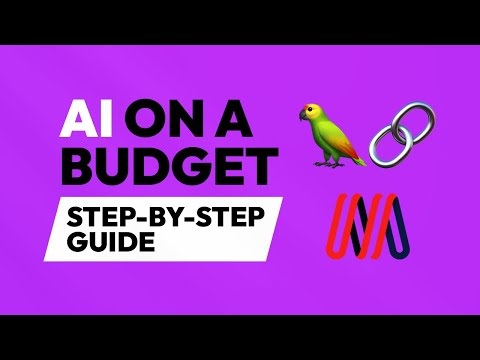

In [1]:
from IPython.display import YouTubeVideo

YouTubeVideo("592CoLjNZQ0", width="560", height="315")

In [ ]:
# @markdown Installing the dependencies
%pip install -q python-dotenv==1.0.0 langchain==0.0.226 text-generation==0.6.0 httpx==0.24.1 gradio==3.36.0

In [ ]:
# @markdown Load .env file
from dotenv import load_dotenv, find_dotenv

_ = load_dotenv(find_dotenv())

In [ ]:
# @markdown Download the [vast.ai](https://cloud.vast.ai/?ref=71973) CLI
import os
import urllib.request

urllib.request.urlretrieve(
    "https://raw.githubusercontent.com/vast-ai/vast-python/7d2f10f/vast.py", "vast"
)
os.chmod("vast", 0o755)

In [ ]:
# @markdown Helper to extract dictionaries from
# @markdown [vast.ai CLI](https://cloud.vast.ai/?ref=71973)
import subprocess
import json


def vast_ai_cmd(args=None):
    if not args:
        args = ["--help"]
    cmd = ["./vast"]
    cmd += args
    result = subprocess.run(cmd, capture_output=True)
    if result.stderr:
        print(result.stderr)
    output = result.stdout.decode()

    if "--raw" in cmd:
        try:
            data = json.loads(output)
            return data
        except json.JSONDecodeError as e:
            print(f"An error occurred: {str(e)}")
    else:
        print(output)


vast_ai_cmd()

In [ ]:
# @markdown vast.ai API key. You can obtain one at [vast.ai](https://cloud.vast.ai/?ref=71973)
import os
from IPython.display import display, Markdown

VAST_AI_API_KEY = os.getenv("VAST_AI_API_KEY", "your_vast_ai_api_key")
if VAST_AI_API_KEY == "your_vast_ai_api_key":
    display(
        Markdown(
            "It appears that you don't have a vast.ai API key. You can obtain one at [vast.ai](https://cloud.vast.ai/?ref=71973)"
        )
    )
    raise AssertionError("Missing vast.ai API key")

vast_ai_cmd(["set", "api-key", VAST_AI_API_KEY])

In [ ]:
# @markdown Searching for suitable hardware to run mosaicml/mpt-30b-chat with quantization.
import pandas as pd

raw_offers = vast_ai_cmd(
    [
        "search",
        "offers",
        "--raw",
        "reliability > 0.9 cuda_vers >= 11.8 num_gpus = 1 gpu_ram >= 47 inet_down >= 500 disk_space >= 130",
        "-o",
        "dph",
    ]
)

offers_count = len(raw_offers)
if offers_count:
    print(f"{offers_count=}")
    offers = pd.DataFrame.from_dict(raw_offers)
else:
    raise AssertionError("No offers, change search query")
offers[
    [
        "id",
        "dph_total",
        "inet_down",
        "cuda_max_good",
        "num_gpus",
        "gpu_name",
        "gpu_ram",
        "cpu_ram",
        "disk_space",
    ]
].head()

In [ ]:
# @markdown Selecting a hardware.
selected_id = 0
selected = offers.iloc[selected_id]
selected.id, selected.dph_total

In [ ]:
# @markdown Starting [Text Generation Inference](https://github.com/huggingface/text-generation-inference) with [MPT-30B-Chat](https://huggingface.co/mosaicml/mpt-30b-chat) model.
res = vast_ai_cmd(
    [
        "create",
        "instance",
        "--raw",
        str(selected.id),
        "--env",
        "-p 80:80",
        "--disk",
        "130",
        "--image",
        "ghcr.io/huggingface/text-generation-inference:0.9.1",
        "--args",
        "--model-id",
        "mosaicml/mpt-30b-chat",
        "--quantize",
        "bitsandbytes",
        "--hostname",
        "::",
    ]
)
instance_id = res["new_contract"]
instance_id

In [ ]:
# @markdown Waiting for instance to become running.
import time
from IPython.display import clear_output

is_running = False
while not is_running:
    instances = vast_ai_cmd(["show", "instances", "--raw"])
    instance = next((i for i in instances if i["id"] == instance_id), None)
    is_running = instance["actual_status"] == "running"
    clear_output(wait=True)
    print(instance)
    time.sleep(5)

In [ ]:
# @markdown Fetching the inference_server_url from instance configuration.
hostname = instance["public_ipaddr"].strip()
port = instance["ports"]["80/tcp"][-1]["HostPort"]
inference_server_url = f"http://{hostname}:{port}"
inference_server_url

In [ ]:
# @markdown Waiting for the TGI health check and displaying logs every 5 seconds.
from IPython.display import clear_output
import time
import httpx

url = f"{inference_server_url}/health"
is_healthy = False
while not is_healthy:
    try:
        res = httpx.get(url)
        is_healthy = res.status_code == 200
    except:
        clear_output(wait=True)
        vast_ai_cmd(["logs", str(instance_id)])
    time.sleep(5)

In [ ]:
# @markdown Creating llm with LangChain's HuggingFaceTextGenInference
from langchain.llms import HuggingFaceTextGenInference

llm = HuggingFaceTextGenInference(
    inference_server_url=inference_server_url,
    max_new_tokens=1024,
    top_k=10,
    top_p=0.95,
    typical_p=0.95,
    stop_sequences=[
        "Human:",
        "AI:",
    ],  # If 'stop_sequences' is not present, the model will generate both sides of the conversation.
    temperature=0.1,
    repetition_penalty=1.03,
)

In [ ]:
# @markdown Creating chat memory.
from langchain.chains.conversation.memory import ConversationBufferWindowMemory

memory = ConversationBufferWindowMemory(
    memory_key="history",
    k=6,
)

In [ ]:
# @markdown Creating ConversationChain.
from langchain.chains import ConversationChain

chat = ConversationChain(llm=llm, memory=memory, verbose=True)

In [ ]:
# @markdown Chat prompt.
chat.prompt

In [ ]:
# @markdown Chat prompt template.
display(Markdown(chat.prompt.template))

In [ ]:
# @markdown 1st message.
display(Markdown(chat.predict(input="hi how are you?")))

In [ ]:
# @markdown 2nd message.
display(Markdown(chat.predict(input="My name is Pavel.")))

In [ ]:
# @markdown Check memory state.
chat.memory

In [ ]:
# @markdown Check if memory is functioning.
display(Markdown(chat.predict(input="What is my name?")))

In [ ]:
# @markdown Next question.
display(
    Markdown(
        chat.predict(input="What is the difference between a method and a function?")
    )
)

In [ ]:
# @markdown Follow up question.
display(Markdown(chat.predict(input="What is more common in OOP?")))

In [ ]:
# @markdown Starting Gradio app with the cachatbot.
import random
import time
import gradio as gr

from langchain.chains.conversation.memory import ConversationBufferWindowMemory


memory = ConversationBufferWindowMemory(
    memory_key="history",
    k=6,
)
chat = ConversationChain(llm=llm, memory=memory)

chatbot = gr.Chatbot()
human_message = gr.Textbox()


def respond(human_message, chat_history):
    ai_message = chat.predict(input=human_message)
    chat_history.append((human_message, ai_message))
    return "", chat_history


demo = gr.Interface(
    fn=respond,
    examples=[
        ["How to square a circle?"],
        ["Compare the physical and chemical properties of hydrogen and oxygen"],
        ["What is the length of human DNA in meters?"],
    ],
    inputs=[human_message, chatbot],
    outputs=[human_message, chatbot],
    allow_flagging="never",
)
try:
    import google.colab

    IN_COLAB = True
except:
    IN_COLAB = False
demo.launch(demo.launch(share=IN_COLAB, debug=True))

In [ ]:
# @markdown Stop the instance.
vast_ai_cmd(["stop", "instance", str(instance_id)])

In [ ]:
# @markdown Start the instance.
vast_ai_cmd(["start", "instance", str(instance_id)])

In [ ]:
# @markdown Destroy the instance.
vast_ai_cmd(["destroy", "instance", str(instance_id)])

In [ ]:
# @markdown Confirm that you are not charged.
vast_ai_cmd(["show", "instances", "--raw"])